1. Montar Google Drive.
Montamos Google Drive para poder acceder a los archivos necesarios (CSV, imágenes y modelos guardados) directamente desde el entorno de Google Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2.Importación de librerías. Se importan todas las librerías necesarias para el proyecto. Estas librerías permiten entrenar, evaluar y visualizar modelos de deep learning sobre el conjunto de imágenes de cartas.

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import requests

from PIL import Image
from io import BytesIO

from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from tensorflow.keras import mixed_precision
from tensorflow.keras import regularizers


warnings.filterwarnings('ignore')

3. Configuración de GPU (si está disponible). Se verifica si hay una GPU disponible en el entorno de ejecución de Colab.  
En caso afirmativo, se configura TensorFlow para usar solo la primera GPU y permitir el crecimiento dinámico de memoria.  
Esto ayuda a evitar errores de memoria y mejora el rendimiento del entrenamiento.

> Si no se detecta GPU, se muestra un aviso indicando cómo activarla desde el menú de Colab.

In [ ]:
import tensorflow as tf
# Verificar dispositivos disponibles
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Establecer uso de solo la primera GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"GPU detectada y configurada: {gpus[0].name}")
    except RuntimeError as e:
        print("Error al configurar la GPU:", e)
else:
    print("No se detectó GPU. Asegúrate de activarla en 'Entorno de ejecución > Cambiar tipo de entorno de ejecución'.")

GPU detectada y configurada: /physical_device:GPU:0


4. Precisión de cálculo: float32.
Se establece la política global de precisión de cálculo en `float32` usando la API `mixed_precision` de TensorFlow. Aunque `mixed_precision` permite combinar `float16` y `float32` para acelerar el entrenamiento, en este caso se fuerza el uso exclusivo de `float32` para garantizar estabilidad y compatibilidad en los cálculos, especialmente en entornos donde `float16` puede causar problemas numéricos.

In [ ]:
mixed_precision.set_global_policy('float32')

5. Definición de rutas de trabajo. Se definen las rutas base a los diferentes conjuntos de datos almacenados en Google Drive. Estas rutas serán utilizadas a lo largo del notebook para cargar imágenes y etiquetas correctamente.

In [ ]:
import os

base_dir = '/content/drive/MyDrive/archive'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
csv_path = os.path.join(base_dir, 'cards.csv')

6. Carga del CSV y exploración inicial de clases (`card type`). Se carga el archivo `cards.csv` como un DataFrame de Pandas.  
Luego, se visualiza la distribución de clases según la columna `'card type'`, que representa el tipo de carta (por ejemplo: ace, king, two, etc.).Esto permite identificar posibles desequilibrios en el número de ejemplos por clase dentro del conjunto de datos.

   class index                   filepaths        labels card type data set
0            0  train/ace of clubs/001.jpg  ace of clubs       ace    train
1            0  train/ace of clubs/002.jpg  ace of clubs       ace    train
2            0  train/ace of clubs/003.jpg  ace of clubs       ace    train
3            0  train/ace of clubs/004.jpg  ace of clubs       ace    train
4            0  train/ace of clubs/005.jpg  ace of clubs       ace    train


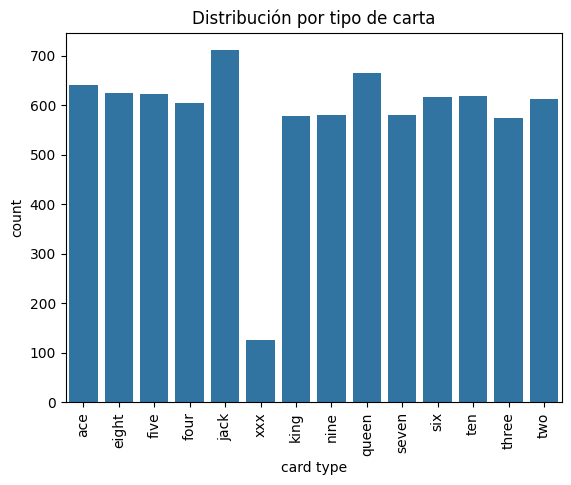

In [ ]:
df = pd.read_csv(csv_path)
print(df.head())

# Visualizar distribución de clases por “card type” o “label”
sns.countplot(x='card type', data=df)
plt.xticks(rotation=90)
plt.title("Distribución por tipo de carta")
plt.show()

7. Preparación del DataFrame para clasificación por tipo de carta (`card type`)

In [ ]:
csv_path = '/content/drive/MyDrive/archive/cards.csv'
df = pd.read_csv(csv_path)

# Verifica las columnas disponibles
print(df.columns)

# Añade la ruta completa al archivo
df['file_path'] = df['filepaths'].apply(lambda x: os.path.join('/content/drive/MyDrive/archive', x))

# Filtra solo las columnas necesarias para clasificación por tipo de carta
df_type = df[['file_path', 'card type']].copy()

Index(['class index', 'filepaths', 'labels', 'card type', 'data set'], dtype='object')


8. División del dataset y visualización de ejemplos (`card type`).

Train size: 6524
Val size: 1631
Found 6523 validated image filenames belonging to 14 classes.
Found 1631 validated image filenames belonging to 14 classes.


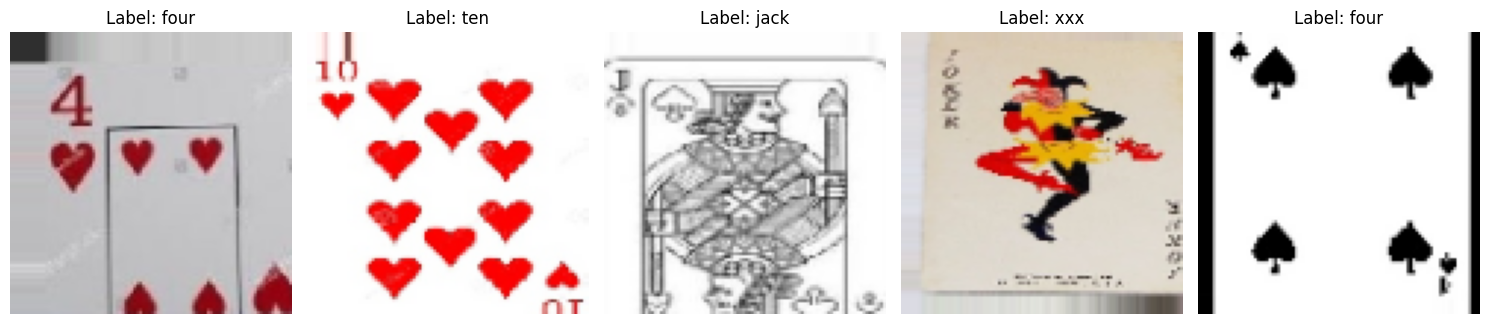

In [ ]:
# Dividir en entrenamiento y validación (80/20)
train_df, val_df = train_test_split(df_type, test_size=0.2, stratify=df_type['card type'], random_state=42)

# Verificamos
print("Train size:", len(train_df))
print("Val size:", len(val_df))

# Preprocesamiento y augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Tamaño esperado por el modelo
IMG_SIZE = (96, 96)
BATCH_SIZE = 32

# Entrenamiento
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='card type',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Validación
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='card type',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Obtener un batch de datos del generador
x_batch, y_batch = next(train_generator)

# Decodificar etiquetas (de one-hot a nombres de clase)
labels_text = list(train_generator.class_indices.keys())
decoded_labels_text = [labels_text[np.argmax(y)] for y in y_batch]

# Visualizar 5 imágenes con su etiqueta
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(x_batch[i])
    axes[i].set_title(f"Label: {decoded_labels_text[i]}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

9. Entrenamiento del modelo CNN para clasificación por tipo de carta (`card type`)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 14)                  │           1,806 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,733,582 (6.61 MB)

 Trainable params: 1,733,582 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

Clase: ace    → Peso: 0.91
Clase: eight  → Peso: 0.93
Clase: five   → Peso: 0.94
Clase: four   → Peso: 0.96
Clase: jack   → Peso: 0.82
Clase: king   → Peso: 1.01
Clase: nine   → Peso: 1.00
Clase: queen  → Peso: 0.88
Clase: seven  → Peso: 1.00
Clase: six    → Peso: 0.95
Clase: ten    → Peso: 0.94
Clase: three  → Peso: 1.02
Clase: two    → Peso: 0.95
Clase: xxx    → Peso: 4.66
Epoch 1/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.1979 - loss: 2.4241 - val_accuracy: 0.5720 - val_loss: 1.3756
Epoch 2/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 36s 174ms/step - accuracy: 0.4278 - loss: 1.7473 - val_accuracy: 0.5849 - val_loss: 1.2936
Epoch 3/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 35s 170ms/step - accuracy: 0.4900 - loss: 1.5505 - val_accuracy: 0.6119 - val_loss: 1.1857
Epoch 4/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 35s 171ms/step - accuracy: 0.5108 - loss: 1.4443 - val_accuracy: 0.6205 - val_loss: 1.1362
Epoch 5/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 35s 170ms/step - accuracy: 0.5433 - loss: 1.3974 - va

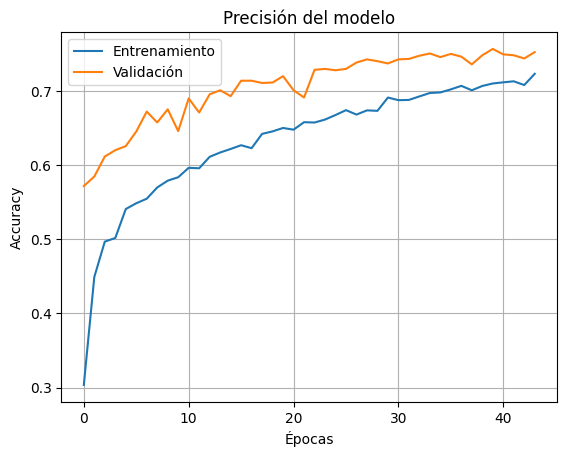

In [ ]:
# Número de clases
num_classes = len(train_generator.class_indices)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Obtener etiquetas de entrenamiento (ordenadas como en el generador)
etiquetas_entrenamiento = train_generator.classes

# Calcular pesos
pesos_clases = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(etiquetas_entrenamiento),
    y=etiquetas_entrenamiento
)

# Convertir a diccionario
class_weight_dict = dict(enumerate(pesos_clases))

# Ver pesos (opcional)
clases = list(train_generator.class_indices.keys())
for i, peso in class_weight_dict.items():
    print(f"Clase: {clases[i]:<6} → Peso: {peso:.2f}")

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/mejor_modelo_cartas.keras',
    monitor='val_loss',
    save_best_only=True
)
EPOCHS = 100

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weight_dict
)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

10. Visualización de predicciones del modelo (`card type`)

Found 265 validated image filenames belonging to 14 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


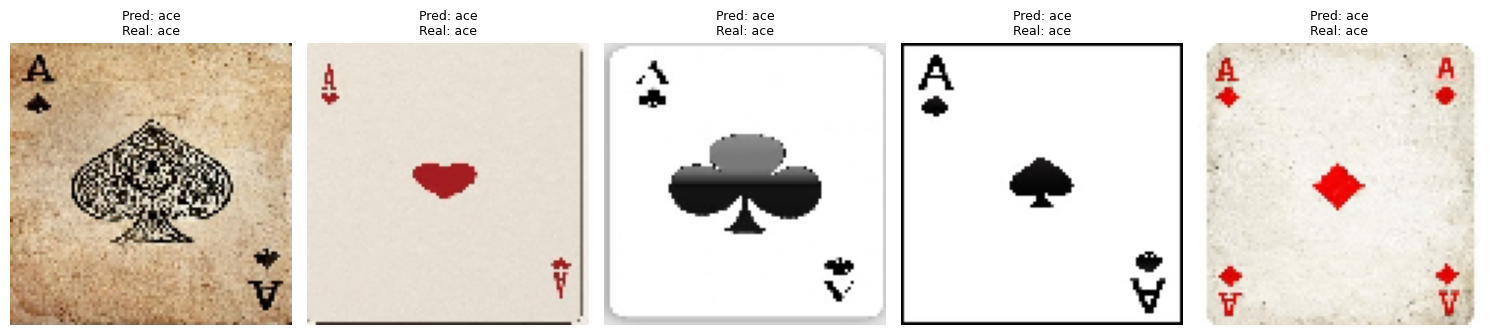

In [ ]:
import random

# 1. Filtrar conjunto de test para card type
df_test_cardtype = df[df['data set'] == 'test'][['file_path', 'card type']].copy()
df_test_cardtype = df_test_cardtype[df_test_cardtype['file_path'].apply(os.path.exists)]

# 2. Crear generador de test
test_datagen_cardtype = ImageDataGenerator(rescale=1./255)

test_generator_cardtype = test_datagen_cardtype.flow_from_dataframe(
    dataframe=df_test_cardtype,
    x_col='file_path',
    y_col='card type',
    target_size=(96, 96),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# 3. Cargar el modelo entrenado
model_cardtype = load_model('/content/drive/MyDrive/mejor_modelo_cartas.keras')

# 4. Obtener un batch de imágenes del generador de test
x_batch, y_true_batch = next(test_generator_cardtype)

# 5. Realizar predicción sobre el batch
predictions = model_cardtype.predict(x_batch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_true_batch, axis=1)

# 6. Decodificar etiquetas desde índices a nombres
labels_text = list(test_generator_cardtype.class_indices.keys())
predicted_labels = [labels_text[i] for i in predicted_classes]
true_labels = [labels_text[i] for i in true_classes]

# 7. Mostrar 5 imágenes aleatorias con predicción y etiqueta real
plt.figure(figsize=(15, 5))
indices = random.sample(range(len(x_batch)), 5)

for i, idx in enumerate(indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_batch[idx])
    plt.title(f"Pred: {predicted_labels[idx]}\nReal: {true_labels[idx]}", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

11. Evaluación final del modelo (`card type`) con conjunto de test. Se evalúa el modelo guardado utilizando el conjunto de test completo para obtener métricas globales de rendimiento

Imagenes de test disponibles: 265
Found 265 validated image filenames belonging to 14 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9001 - loss: 0.3416
Perdida (loss): 0.4150
Precision (accuracy): 0.8792
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


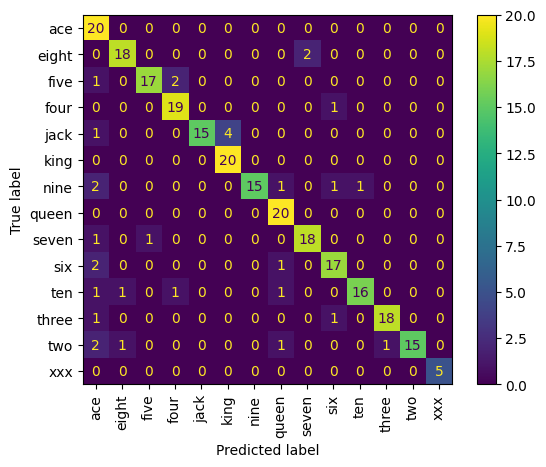

In [ ]:
# Filtrar conjunto de test
df_test = df[df['data set'] == 'test'].copy()
df_test['file_path'] = df_test['filepaths'].apply(lambda x: os.path.join('/content/drive/MyDrive/archive', x))
df_test = df_test[['file_path', 'card type']].copy()

# Verificar que las rutas existen
df_test = df_test[df_test['file_path'].apply(os.path.exists)].copy()
print(f"Imagenes de test disponibles: {len(df_test)}")

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='file_path',
    y_col='card type',
    target_size=(96, 96),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

modelo = load_model('/content/drive/MyDrive/mejor_modelo_cartas.keras')

loss, accuracy = modelo.evaluate(test_generator)
print(f"Perdida (loss): {loss:.4f}")
print(f"Precision (accuracy): {accuracy:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicciones
y_pred_probs = modelo.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Matriz de confusion
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(xticks_rotation=90)

12. Reporte de clasificación por tipo de carta (`card type`). Se genera un reporte detallado de rendimiento del modelo sobre el conjunto de test usando `classification_report` de `sklearn`. Este informe incluye, para cada clase (`card type`). Este reporte permite detectar clases que tienen mal rendimiento, posibles confusiones del modelo y si hay clases infrarrepresentadas.

In [58]:
# 1. Obtener las predicciones sobre todo el conjunto de test
y_pred_probs = model_cardtype.predict(test_generator_cardtype)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator_cardtype.classes

# 2. Obtener los nombres de las clases
labels_cardtype = list(test_generator_cardtype.class_indices.keys())

# 3. Generar el reporte de clasificación
reporte = classification_report(
    y_true,
    y_pred,
    target_names=labels_cardtype,
    digits=2
)

# 4. Mostrar reporte
print("Reporte de Clasificación (Card Type):")
print(reporte)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Reporte de Clasificación (Card Type):
              precision    recall  f1-score   support

         ace       0.65      1.00      0.78        20
       eight       0.90      0.90      0.90        20
        five       0.94      0.85      0.89        20
        four       0.86      0.95      0.90        20
        jack       1.00      0.75      0.86        20
        king       0.83      1.00      0.91        20
        nine       1.00      0.75      0.86        20
       queen       0.83      1.00      0.91        20
       seven       0.90      0.90      0.90        20
         six       0.85      0.85      0.85        20
         ten       0.94      0.80      0.86        20
       three       0.95      0.90      0.92        20
         two       1.00      0.75      0.86        20
         xxx       1.00      1.00      1.00         5

    accuracy                           0.88       265
   macro avg       0.90      0.89      0.89       265
weig

13. Pruebas con imágenes nuevas (`card type`). Se define una función para cargar imágenes externas y predecir su tipo de carta (`card type`) con el modelo entrenado.


Imagen: imagen_prueba_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


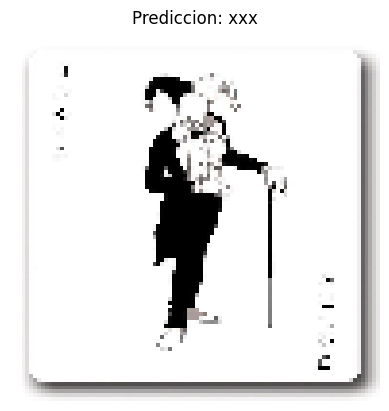


Imagen: imagen_prueba_4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


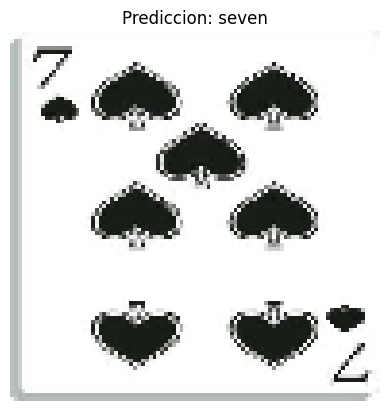


Imagen: imagen_prueba_2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


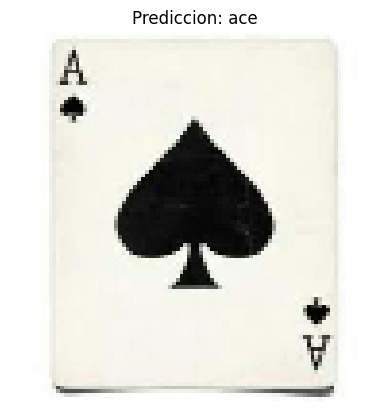


Imagen: imagen_prueba_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


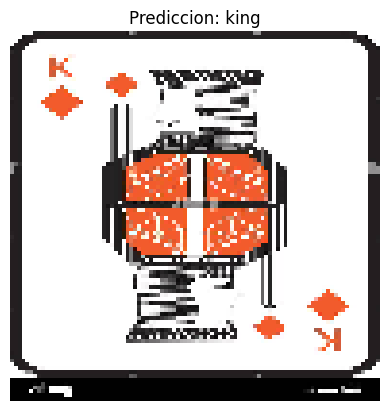

In [ ]:
from tensorflow.keras.preprocessing import image

# Cargar modelo y clases
modelo = load_model('/content/drive/MyDrive/mejor_modelo_cartas.keras')
class_indices = train_generator.class_indices
indices_to_class = {v: k for k, v in class_indices.items()}

# Función para predecir una imagen
def predecir_carta(imagen_path):
    img = image.load_img(imagen_path, target_size=(96, 96))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = modelo.predict(img_array)
    clase_predicha = np.argmax(pred)
    nombre_clase = indices_to_class[clase_predicha]

    # Mostrar
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediccion: {nombre_clase}')
    plt.show()

    return nombre_clase

# Ruta a la carpeta con imágenes nuevas
carpeta_prueba = '/content/drive/MyDrive/cartas_nuevas'

# Predecir cada imagen
for archivo in os.listdir(carpeta_prueba):
    if archivo.lower().endswith(('.jpg', '.jpeg', '.png')):
        ruta_completa = os.path.join(carpeta_prueba, archivo)
        print(f'\nImagen: {archivo}')
        predecir_carta(ruta_completa)

14. Limpieza de memoria tras uso del modelo `cardtype`.

In [ ]:
from tensorflow.keras import backend as K
import gc
K.clear_session()
gc.collect()
print("Memoria liberada tras modelo 'cardtype'")

Memoria liberada tras modelo 'cardtype'


15. Exploración inicial de clases completas (`labels`). Se inicia la Fase 2, centrada en la clasificación por etiqueta completa (`labels`), que representa el valor y el palo de cada carta (por ejemplo: `'ace of hearts'`, `'king of clubs'`, `'joker'`, etc.).

   class index                   filepaths        labels card type data set
0            0  train/ace of clubs/001.jpg  ace of clubs       ace    train
1            0  train/ace of clubs/002.jpg  ace of clubs       ace    train
2            0  train/ace of clubs/003.jpg  ace of clubs       ace    train
3            0  train/ace of clubs/004.jpg  ace of clubs       ace    train
4            0  train/ace of clubs/005.jpg  ace of clubs       ace    train


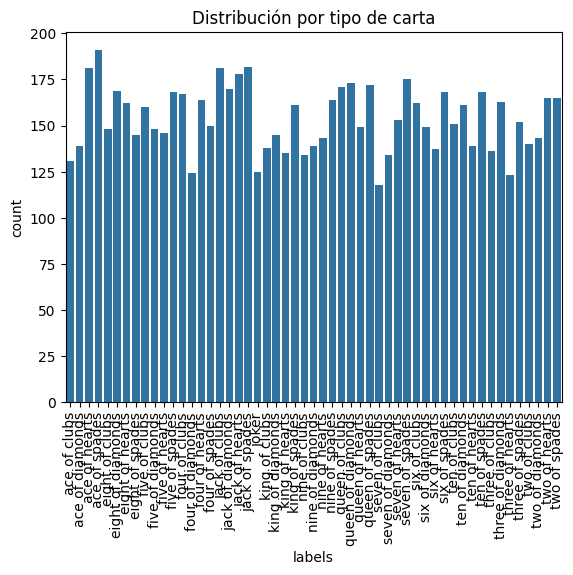

In [ ]:
df = pd.read_csv(csv_path)
print(df.head())

# Visualizar distribución de clases por “card type” o “label”
sns.countplot(x='labels', data=df)
plt.xticks(rotation=90)
plt.title("Distribución por tipo de carta")
plt.show()

16. Preparación del DataFrame para clasificación por `labels` (53 clases). Se prepara el conjunto de datos para entrenar un modelo que clasifique cada carta según su etiqueta completa (`labels`), que incluye el valor y el palo.

In [ ]:
# Cargar CSV
csv_path = '/content/drive/MyDrive/archive/cards.csv'
df = pd.read_csv(csv_path)

# Añadir la ruta completa al archivo
df['file_path'] = df['filepaths'].apply(lambda x: os.path.join('/content/drive/MyDrive/archive', x))

# Filtra solo las columnas necesarias para clasificación por etiqueta completa (53 clases)
df_labels = df[['file_path', 'labels']].copy()

# Visualizar clases disponibles (opcional)
print("Número de clases:", df_labels['labels'].nunique())
print("Algunas clases:", df_labels['labels'].unique()[:5])

Número de clases: 53
Algunas clases: ['ace of clubs' 'ace of diamonds' 'ace of hearts' 'ace of spades'
 'eight of clubs']


17. División del dataset y visualización de ejemplos (`labels`)

Train size (labels): 6524
Val size (labels): 1631
Found 6523 validated image filenames belonging to 53 classes.
Found 1631 validated image filenames belonging to 53 classes.


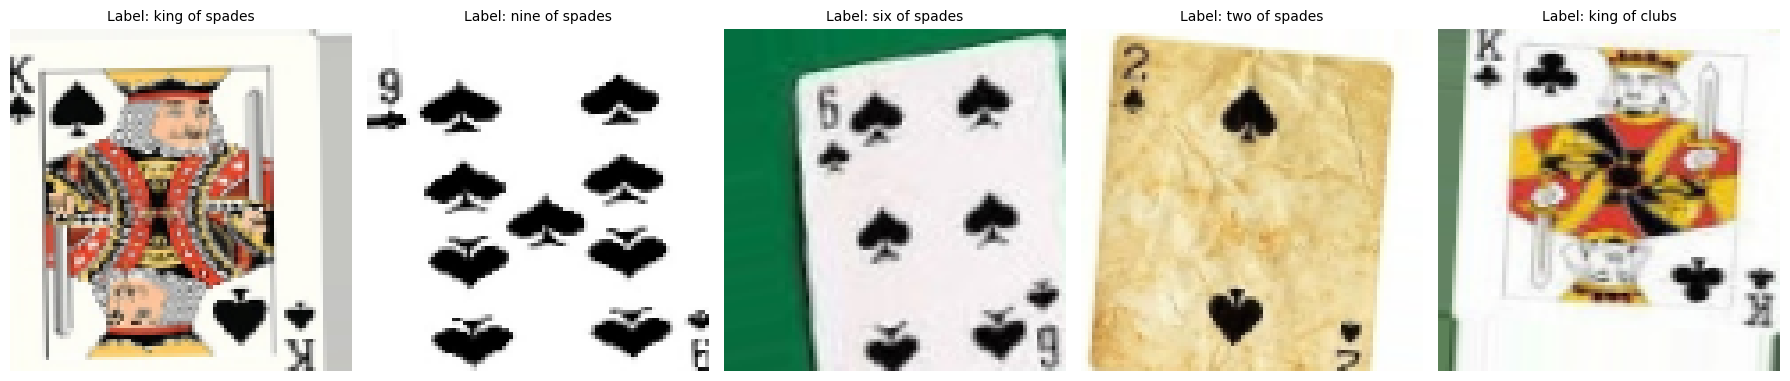

In [ ]:
# Dividir en entrenamiento y validación (80/20) con labels
train_df_labels, val_df_labels = train_test_split(
    df_labels,
    test_size=0.2,
    stratify=df_labels['labels'],
    random_state=42
)

# Verificamos
print("Train size (labels):", len(train_df_labels))
print("Val size (labels):", len(val_df_labels))

# Preprocesamiento y augmentación
train_datagen_53 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)

val_datagen_53 = ImageDataGenerator(rescale=1./255)

# Tamaño esperado por el modelo
IMG_SIZE = (96, 96)
BATCH_SIZE = 32

# Generador de entrenamiento (53 clases)
train_generator_53 = train_datagen_53.flow_from_dataframe(
    dataframe=train_df_labels,
    x_col='file_path',
    y_col='labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Generador de validación (53 clases)
val_generator_53 = val_datagen_53.flow_from_dataframe(
    dataframe=val_df_labels,
    x_col='file_path',
    y_col='labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Obtener un batch de datos del generador de 53 clases
x_batch_53, y_batch_53 = next(train_generator_53)

# Decodificar etiquetas (de one-hot a nombres de clase)
labels_text_53 = list(train_generator_53.class_indices.keys())
decoded_labels_text_53 = [labels_text_53[np.argmax(y)] for y in y_batch_53]

# Visualizar 5 imágenes con sus etiquetas
fig, axes = plt.subplots(1, 5, figsize=(18, 5))
for i in range(5):
    axes[i].imshow(x_batch_53[i])
    axes[i].set_title(f"Label: {decoded_labels_text_53[i]}", fontsize=10)
    axes[i].axis("off")
plt.tight_layout()
plt.show()

18. Entrenamiento del modelo CNN para clasificación completa (`labels` - 53 clases)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 53)                  │           6,837 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,738,613 (6.63 MB)

 Trainable params: 1,738,613 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Clase: ace of clubs         → Peso: 1.18
Clase: ace of diamonds      → Peso: 1.11
Clase: ace of hearts        → Peso: 0.85
Clase: ace of spades        → Peso: 0.80
Clase: eight of clubs       → Peso: 1.03
Clase: eight of diamonds    → Peso: 0.91
Clase: eight of hearts      → Peso: 0.95
Clase: eight of spades      → Peso: 1.06
Clase: five of clubs        → Peso: 0.96
Clase: five of diamonds     → Peso: 1.03
Clase: five of hearts       → Peso: 1.05
Clase: five of spades       → Peso: 0.92
Clase: four of clubs        → Peso: 0.92
Clase: four of diamonds     → Peso: 1.24
Clase: four of hearts       → Peso: 0.94
Clase: four of spades       → Peso: 1.03
Clase: jack of clubs        → Peso: 0.85
Clase: jack of diamonds     → Peso: 0.90
Clase: jack of hearts       → Peso: 0.87
Clase: jack of spades       → Peso: 0.84
Clase: joker                → Peso: 1.23
Clase: king of clubs        → Peso: 1.12
Clase: king of diamonds     → Peso: 1.06
Clase: king of hearts       → Peso: 1.14
Clase: king of s

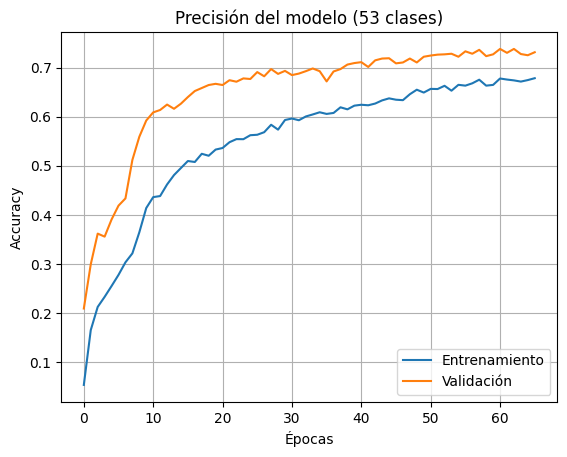

In [ ]:
# Número de clases
num_classes_53 = len(train_generator_53.class_indices)

# Modelo CNN
model_53 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes_53, activation='softmax')
])

# Compilar
model_53.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_53.summary()

# Etiquetas de entrenamiento para 53 clases
etiquetas_entrenamiento_53 = train_generator_53.classes

# Calcular pesos
pesos_clases_53 = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(etiquetas_entrenamiento_53),
    y=etiquetas_entrenamiento_53
)

# Convertir a diccionario
class_weight_dict_53 = dict(enumerate(pesos_clases_53))

# Mostrar (opcional)
clases_53 = list(train_generator_53.class_indices.keys())
for i, peso in class_weight_dict_53.items():
    print(f"Clase: {clases_53[i]:<20} → Peso: {peso:.2f}")

early_stop_53 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_53 = ModelCheckpoint(
    filepath='/content/drive/MyDrive/mejor_modelo_cartas_53.keras',
    monitor='val_loss',
    save_best_only=True
)

EPOCHS = 100

history_53 = model_53.fit(
    train_generator_53,
    validation_data=val_generator_53,
    epochs=EPOCHS,
    callbacks=[early_stop_53, checkpoint_53],
    class_weight=class_weight_dict_53
)

plt.plot(history_53.history['accuracy'], label='Entrenamiento')
plt.plot(history_53.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo (53 clases)')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

19. Visualización de predicciones del modelo (`labels` - 53 clases). Se prueba el modelo entrenado con imágenes del conjunto de test. El objetivo es observar visualmente el rendimiento real del clasificador.

Found 265 validated image filenames belonging to 53 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


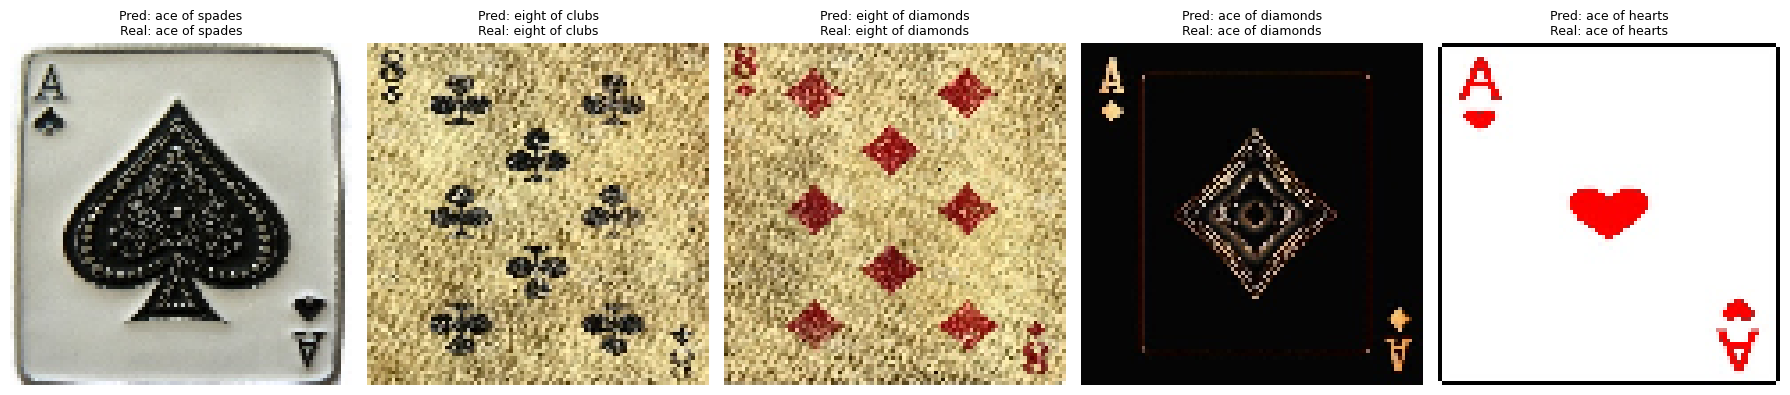

In [ ]:
# 1. Filtrar conjunto de test para labels
df_test_labels = df[df['data set'] == 'test'][['file_path', 'labels']].copy()
df_test_labels = df_test_labels[df_test_labels['file_path'].apply(os.path.exists)]

# 2. Crear generador de test para 53 clases
test_datagen_53 = ImageDataGenerator(rescale=1./255)

test_generator_53 = test_datagen_53.flow_from_dataframe(
    dataframe=df_test_labels,
    x_col='file_path',
    y_col='labels',
    target_size=(96, 96),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# 3. Cargar el modelo de 53 clases
model_53 = load_model('/content/drive/MyDrive/mejor_modelo_cartas_53.keras')

# 4. Obtener un batch de imágenes del generador de test
x_batch_53, y_true_batch_53 = next(test_generator_53)

# 5. Realizar predicción sobre el batch
predictions_53 = model_53.predict(x_batch_53)
predicted_classes_53 = np.argmax(predictions_53, axis=1)
true_classes_53 = np.argmax(y_true_batch_53, axis=1)

# 6. Decodificar etiquetas desde índices a nombres
labels_text_53 = list(test_generator_53.class_indices.keys())
predicted_labels_53 = [labels_text_53[i] for i in predicted_classes_53]
true_labels_53 = [labels_text_53[i] for i in true_classes_53]

# 7. Mostrar 5 imágenes aleatorias con predicción y etiqueta real
plt.figure(figsize=(18, 5))
indices = random.sample(range(len(x_batch_53)), 5)

for i, idx in enumerate(indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_batch_53[idx])
    plt.title(f"Pred: {predicted_labels_53[idx]}\nReal: {true_labels_53[idx]}", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

20. Evaluación final del modelo (`labels`) con conjunto de test. Se realiza la evaluación completa del modelo entrenado para 53 clases (`labels`) utilizando el conjunto de test

Imágenes de test disponibles: 265
Found 265 validated image filenames belonging to 53 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9124 - loss: 0.3170
Pérdida (loss): 0.3857
Precisión (accuracy): 0.8943
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


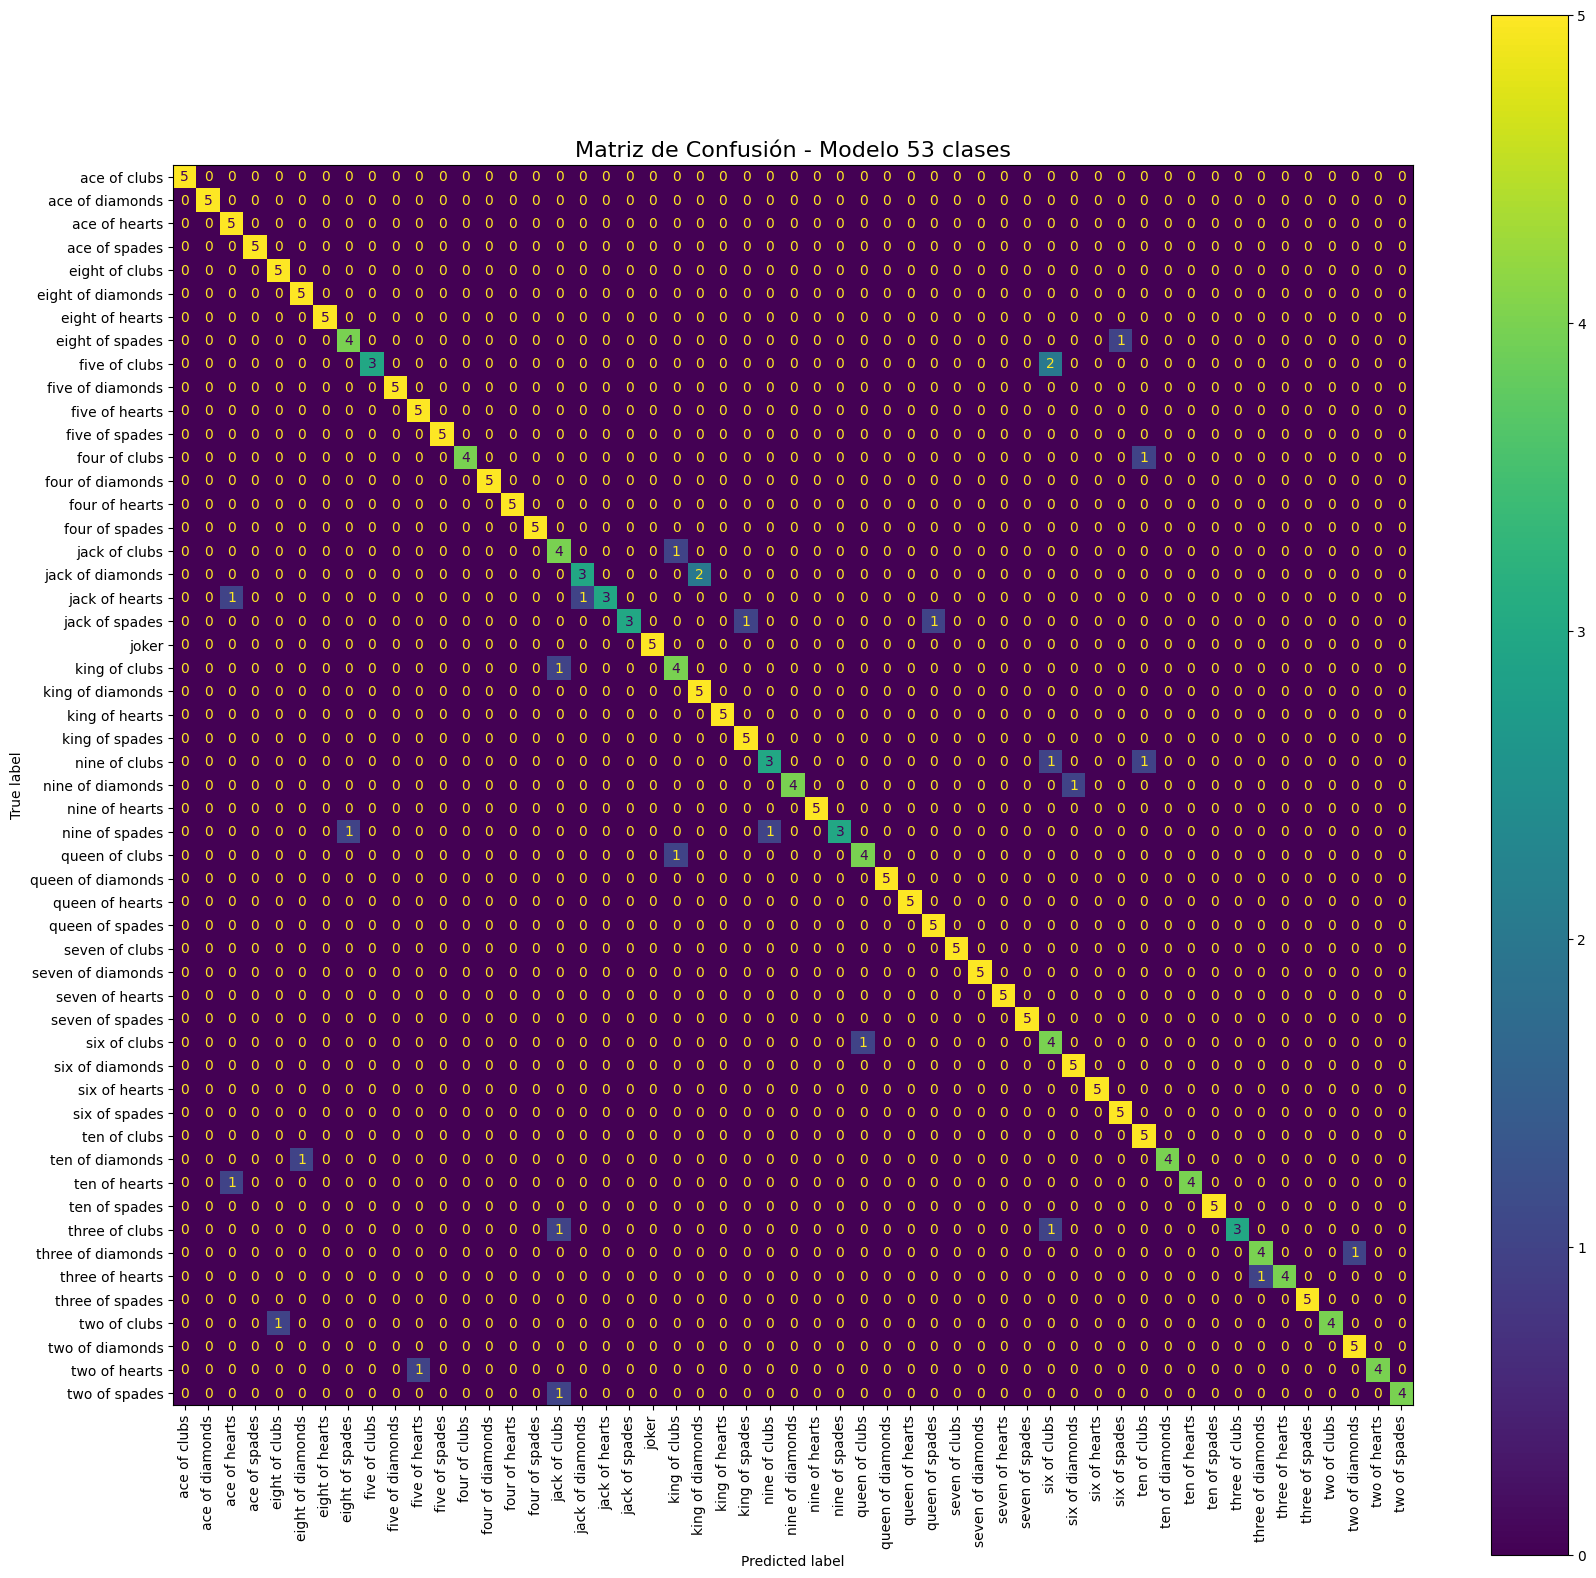

In [ ]:
# Filtrar conjunto de test para 53 clases
df_test_labels = df[df['data set'] == 'test'].copy()
df_test_labels['file_path'] = df_test_labels['filepaths'].apply(lambda x: os.path.join('/content/drive/MyDrive/archive', x))
df_test_labels = df_test_labels[['file_path', 'labels']].copy()
df_test_labels = df_test_labels[df_test_labels['file_path'].apply(os.path.exists)].copy()

print(f"Imágenes de test disponibles: {len(df_test_labels)}")

# Generador de test
test_datagen_53 = ImageDataGenerator(rescale=1./255)

test_generator_53 = test_datagen_53.flow_from_dataframe(
    dataframe=df_test_labels,
    x_col='file_path',
    y_col='labels',
    target_size=(96, 96),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Cargar el modelo de 53 clases
modelo_53 = load_model('/content/drive/MyDrive/mejor_modelo_cartas_53.keras')

# Evaluar
loss, accuracy = modelo_53.evaluate(test_generator_53)
print(f"Pérdida (loss): {loss:.4f}")
print(f"Precisión (accuracy): {accuracy:.4f}")

# Matriz de confusión
y_pred_probs = modelo_53.predict(test_generator_53)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator_53.classes
class_names = list(test_generator_53.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(20, 20))  # Cambia el tamaño aquí
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(include_values=True, xticks_rotation=90, ax=ax, cmap='viridis', colorbar=True)
plt.title("Matriz de Confusión - Modelo 53 clases", fontsize=16)
plt.grid(False)
plt.show()


21. Reporte de clasificación por etiqueta completa (`labels` - 53 clases). Se genera un reporte detallado del rendimiento del modelo en el conjunto de test utilizando `classification_report` de `sklearn`.

In [ ]:
# 1. Obtener las predicciones sobre todo el conjunto de test
y_pred_probs_53 = model_53.predict(test_generator_53)
y_pred_53 = np.argmax(y_pred_probs_53, axis=1)
y_true_53 = test_generator_53.classes

# 2. Obtener los nombres de las clases
labels_53 = list(test_generator_53.class_indices.keys())

# 3. Generar el reporte de clasificación
reporte_53 = classification_report(
    y_true_53,
    y_pred_53,
    target_names=labels_53,
    digits=2
)

# 4. Mostrar reporte
print("Reporte de Clasificación (Labels - 53 clases):")
print(reporte_53)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
📊 Reporte de Clasificación (Labels - 53 clases):
                   precision    recall  f1-score   support

     ace of clubs       1.00      1.00      1.00         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       0.71      1.00      0.83         5
    ace of spades       1.00      1.00      1.00         5
   eight of clubs       0.83      1.00      0.91         5
eight of diamonds       0.83      1.00      0.91         5
  eight of hearts       1.00      1.00      1.00         5
  eight of spades       0.80      0.80      0.80         5
    five of clubs       1.00      0.60      0.75         5
 five of diamonds       1.00      1.00      1.00         5
   five of hearts       0.83      1.00      0.91         5
   five of spades       1.00      1.00      1.00         5
    four of clubs       1.00      0.80      0.89         5
 four of diamonds       1.00      1.00      1.00         5
   four of hearts       1.0

22. Pruebas con imágenes nuevas (`labels` - 53 clases). Se define una función para utilizar el modelo entrenado con `labels` y clasificar imágenes externas (no vistas durante el entrenamiento).


➡️ Imagen: imagen_prueba_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


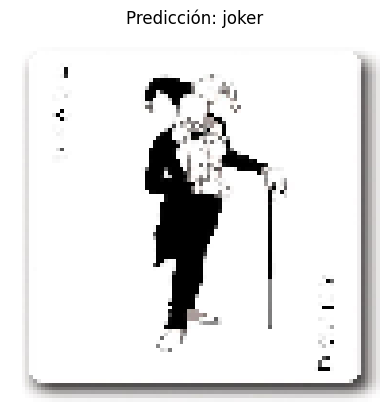


➡️ Imagen: imagen_prueba_4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


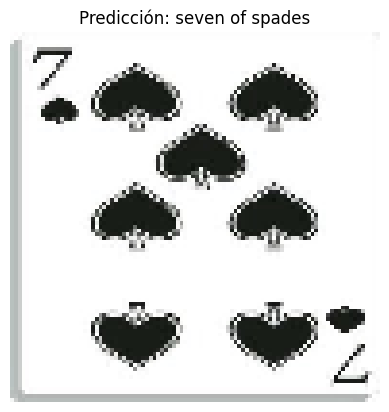


➡️ Imagen: imagen_prueba_2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


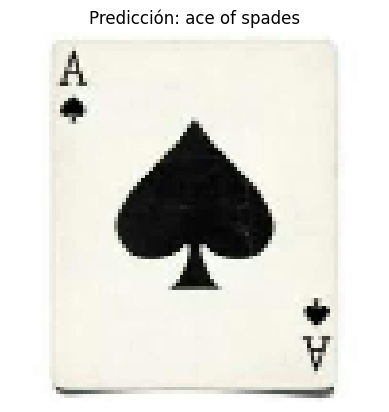


➡️ Imagen: imagen_prueba_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


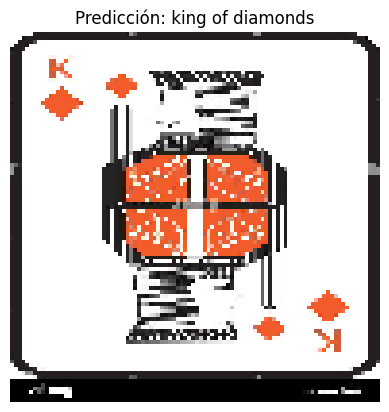

In [ ]:

# Cargar el modelo de 53 clases
modelo_53 = load_model('/content/drive/MyDrive/mejor_modelo_cartas_53.keras')

# Diccionario de clases desde el generador de 53 clases
class_indices_53 = train_generator_53.class_indices
indices_to_class_53 = {v: k for k, v in class_indices_53.items()}

# Función para predecir una imagen nueva
def predecir_carta_53(imagen_path):
    img = image.load_img(imagen_path, target_size=(96, 96))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = modelo_53.predict(img_array)
    clase_predicha = np.argmax(pred)
    nombre_clase = indices_to_class_53[clase_predicha]

    # Mostrar imagen con predicción
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicción: {nombre_clase}')
    plt.show()

    return nombre_clase

# Ruta a la carpeta con imágenes nuevas
carpeta_prueba = '/content/drive/MyDrive/cartas_nuevas'

# Predecir cada imagen
for archivo in os.listdir(carpeta_prueba):
    if archivo.lower().endswith(('.jpg', '.jpeg', '.png')):
        ruta_completa = os.path.join(carpeta_prueba, archivo)
        print(f'\n➡️ Imagen: {archivo}')
        predecir_carta_53(ruta_completa)